In [17]:
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib import patches
from torchvision import io
import torch
import numpy as np
from CONFIG import config
from datalib import build_data_loader, load_data
from utils.utils import count_model_params
from torchinfo import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Visualization

* Here, we investigate the transforms on train dataset. We compare the data in a sequence before and after the transformations being applied. 
* The transforms are implemented to equally to all the samples in a sequence, preserving the time consistanct of the video sequence.
* Each new sequence gets fresh random decisions for augmentation. This is done in MoviC.py file line 50 (self.transforms.reset_sequence(sequence_idx=idx), num_epochs=self.num_epochs) resets the flags for horizontal and vertical flips.
* For the sake of having the same transformation on all data in a sequence, we needed to have different seeds per sequence. But at the same time we need a base/stable seed during training the model and initializeing the tensors. To solve this problem, we considered the seed for training as `base_seed` which is increased by idx - the index of the sequence in the dataset - and also a random value in range(epoch). This ensures both consistancy during data augmentatin per sequence, diversity per sequence/epoch, and also during training procecss for tensors (having a defined base-seed).( This is done in _make_sequence_decisions() function line 35 in MoviC.py). Although this approach provides deterministicc results for agumentation `per_sequence`, is it non-deterministic `per run`!

* For each sequence, the choosen augmentation can be aither vertical, horizontal, both, or neither! This is also done in _make_sequence_decisions() function in MoviC.py. We consider independent probabilities for each augmentation:

    - should_hflip = random.random() < 0.3: 30% chance of horizontal flip.
    - should_vflip = random.random() < 0.7: 70% chance of vertical flip.

    Since these are independent, the possible outcomes per sequence are:

    - Neither: (1-0.3) * (1-0.7) = 70% * 30% = 21% probability.

    - Horizontal only: 30% * 30% = 9% probability.

    - Vertical only: 70% * 70% = 49% probability.

    - Both: 30% * 70% = 21% probability.

    

In [2]:

# Apply transforms to ENTIRE sequence using transform pipeline

path = config['data']['dataset_path']
# train_dataset = load_data(path, split='train', use_transforms=False)
# train_dataset_transformed = load_data(path, split='train', use_transforms=True)


In [3]:
# from utils.utils import plot_sequence_comparison


# idx = np.random.randint(0, len(train_dataset))

# rgbs_orig, masks_orig, flows_orig, coords_orig = train_dataset[idx]
# rgbs_trans, masks_trans, flows_trans, coords_trans = train_dataset_transformed[idx]


# plot_sequence_comparison(
#                         rgbs_orig, masks_orig, flows_orig, coords_orig,
#                         rgbs_trans, masks_trans, flows_trans, coords_trans,
#                         n_rows=6, sequence_idx=idx
#                         )

### Datalloaders and modality shapes

In [4]:
val_dataset = load_data(path, split='validation', use_transforms=True)

# train_loader= build_data_loader(train_dataset, split='train')
val_loader = build_data_loader(val_dataset, split='validation')


[INFO] - VALIDATION Data Loaded: Coordinates: 250, Masks: 250, RGB videos:  250, Flows:  250


In [5]:
## Verifying the dataloader  
rgbs, masks, flows, coords = next(iter(val_loader))

# Send all tensors to device
rgbs = rgbs.to(device)
flows = flows.to(device)

# Move all mask tensors to device
for k in masks:
    masks[k] = masks[k].to(device)

# Move all coords tensors to device
for k in coords:
    coords[k] = coords[k].to(device)

print(f"RGBs shape: {rgbs.shape}\nFlows shape: {flows.shape}\nMasks shape: {masks['masks'].shape} \nCoords com shape: {coords['com'].shape}\nCoords bbxs shape: {coords['bbox'].shape}")


RGBs shape: torch.Size([32, 24, 3, 128, 128])
Flows shape: torch.Size([32, 24, 3, 128, 128])
Masks shape: torch.Size([32, 24, 128, 128]) 
Coords com shape: torch.Size([32, 24, 11, 2])
Coords bbxs shape: torch.Size([32, 24, 11, 4])


In [6]:

# def extract_object_specific_frames_from_masks(images, masks, num_objects):
#     """
#     images: Tensor of shape [B, T, C, H, W]
#     masks: Tensor of shape [B, T, H, W] with int values from 0 to num_objects-1
#     num_objects: int, number of unique objects (including background if needed)

#     Returns:
#         object_frames: Tensor of shape [B, T, num_objects, C, H, W]
#     """
#     B, T, C, H, W = images.shape
#     device = images.device

#     # Expand images for each object
#     object_frames = torch.zeros(B, T, num_objects, C, H, W, device=device, dtype=images.dtype)

#     for obj_id in range(num_objects):
#         # Create mask for this object: shape [B, T, 1, H, W]
#         obj_mask = (masks == obj_id).unsqueeze(2)  # [B, T, 1, H, W]
#         # Broadcast mask to all channels
#         obj_mask = obj_mask.expand(-1, -1, C, -1, -1)  # [B, T, C, H, W]
#         # Apply mask
#         object_frames[:, :, obj_id] = images * obj_mask

#     return object_frames

# num_objects = 11
# object_frames = extract_object_specific_frames_from_masks(rgbs, masks['masks'], num_objects)
# object_frames.shape

In [7]:
# # Choose the first batch and first time step
# batch_idx = 31
# time_idx = 11

# # object_frames shape: [B, T, num_objects, C, H, W]
# # We'll print all object frames for this batch and time step
# num_objects = len(object_frames[batch_idx][time_idx])

# # Plot the original image
# plt.figure(figsize=(3, 3))
# plt.imshow(rgbs[batch_idx, time_idx].permute(1, 2, 0).cpu().numpy())
# plt.title("Original Image")
# plt.axis("off")
# plt.show()

# plt.figure(figsize=(3 * num_objects, 3))
# for obj_id in range(num_objects):
#     obj_img = object_frames[batch_idx, time_idx, obj_id]  # shape: [C, H, W]
#     plt.subplot(1, num_objects, obj_id + 1)
#     # If the object frame is all zeros, skip displaying
#     if obj_img.abs().sum() == 0:
#         plt.title(f"Object {obj_id}\n(empty)")
#         plt.axis("off")
#         continue
#     plt.imshow(obj_img.permute(1, 2, 0).cpu().numpy())
#     plt.title(f"Object {obj_id+1}")
#     plt.axis("off")
# plt.show()


In [8]:
# def extract_object_specific_frames_from_bboxes(images, bboxes):
#     """
#     images: Tensor of shape [B, T, C, H, W]
#     bboxes: Tensor of shape [B, T, num_objects, 4] (x1, y1, x2, y2) in pixel coordinates

#     Returns:
#         object_frames: Tensor of shape [B, T, num_objects, C, H, W]
#     """
#     B, T, C, H, W = images.shape
#     device = images.device
#     num_objects = bboxes.shape[2]

#     # Prepare output tensor
#     object_frames = torch.zeros(B, T, num_objects, C, H, W, device=device, dtype=images.dtype)

#     for obj_id in range(num_objects):
#         for b in range(B):
#             for t in range(T):
#                 x1, y1, x2, y2 = bboxes[b, t, obj_id]
#                 # Clamp coordinates to image bounds and convert to int
#                 x1 = int(torch.clamp(x1, 0, W-1).item())
#                 y1 = int(torch.clamp(y1, 0, H-1).item())
#                 x2 = int(torch.clamp(x2, 0, W-1).item())
#                 y2 = int(torch.clamp(y2, 0, H-1).item())
#                 # Ensure valid bbox
#                 if x2 > x1 and y2 > y1:
#                     # Copy the region from the image to the corresponding location in object_frames
#                     object_frames[b, t, obj_id, :, y1:y2, x1:x2] = images[b, t, :, y1:y2, x1:x2]
#                 # else: leave as zeros (background)
#     return object_frames

# object_frames = extract_object_specific_frames_from_bboxes(rgbs, coords['bbox'])
# object_frames.shape


In [9]:
# # Plot the original image and the extracted object frames from extract_object_specific_frames_from_bboxes

# BATCH_IDX = 31
# SEQ_IDX = 11

# # Plot the original image
# plt.figure(figsize=(3, 3))
# plt.imshow(rgbs[BATCH_IDX, SEQ_IDX].permute(1, 2, 0).cpu().numpy())
# plt.title("Original Image")
# plt.axis("off")
# plt.show()

# # Plot all object frames for this sample and time step (from bboxes)
# num_objects = object_frames.shape[2]
# fig, axes = plt.subplots(1, num_objects, figsize=(3 * num_objects, 3))
# for obj_id in range(num_objects):
#     ax = axes[obj_id] if num_objects > 1 else axes
#     obj_img = object_frames[BATCH_IDX, SEQ_IDX, obj_id]
#     ax.imshow(obj_img.permute(1, 2, 0).cpu().numpy())
#     ax.set_title(f"Object {obj_id+1}")
#     ax.axis("off")
# plt.show()



### Patchifier

Patchified Shape: torch.Size([32, 24, 64, 768])
Number of patches: 64
Patch size: 16


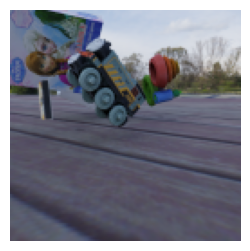

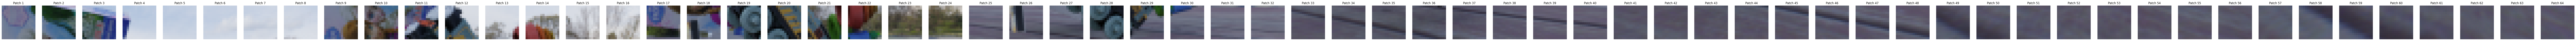

In [10]:
from model.model_utils import Patchifier

BATCH_IDX = 4
seq_len = 5
img = rgbs[BATCH_IDX, seq_len]

plt.figure(figsize=(3, 3))
plt.imshow(img.permute(1, 2, 0).cpu().numpy())
plt.axis("off")

patch_size = config['data']['patch_size'] # num of H and W pixels of each patch
patchifier = Patchifier(patch_size)
patch_data = patchifier(rgbs)
print(f"Patchified Shape: {patch_data.shape}") # (B, seq_len, num_patch_H * num_patch_W, 3 * 32 * 32)

num_patches = patch_data.shape[2] # num_patches = num_patch_H * num_patch_W
print(f"Number of patches: {num_patches}")
print(f"Patch size: {patch_size}")
fig, ax = plt.subplots(1, num_patches)
fig.set_size_inches(3 * num_patches, 3)
for i in range(num_patches):
    cur_patch = patch_data[BATCH_IDX, seq_len, i].reshape(3, patch_size, patch_size)
    ax[i].imshow(cur_patch.permute(1, 2, 0).cpu().numpy())
    ax[i].set_title(f"Patch {i+1}")
    ax[i].axis("off")

plt.show()

## ***1. Holistic scene representation***

 *  **Holistic Transformer-AutoEncoder Module**

In [12]:
from model.holistic_encoder import HolisticEncoder
from model.holistic_decoder import HolisticDecoder
from model.ocvp import TransformerAutoEncoder

In [13]:

holistic_encoder = HolisticEncoder().to(device)

holistic_decoder = HolisticDecoder().to(device)

model = TransformerAutoEncoder(holistic_encoder, holistic_decoder).to(device)

# summary(model, input_size= rgbs.shape)

In [ ]:
encoded_features = holistic_encoder(rgbs)
print("Encoded Features shape:\n", encoded_features.shape)
recons, loss = holistic_decoder(encoded_features)
print(f"Reconstructed image shape:\n", recons.shape)


In [ ]:
recons = model(rgbs)
print(recons.shape)

* **Holositic Transformer-Predictor Module**

In [14]:
from model.holistic_predictor import HolisticTransformerPredictor
from model.predictor_wrapper import PredictorWrapper
from model.ocvp import TransformerPredictor

In [16]:
holistic_predictor = HolisticTransformerPredictor()
holistic_predictor= PredictorWrapper(holistic_predictor)
model = TransformerPredictor(holistic_encoder, holistic_decoder, holistic_predictor)

# summary(model, input_size= rgbs.shape)


In [ ]:
encoded_features = holistic_encoder(rgbs, masks, coords)
preds, loss = model(encoded_features)
preds.shape

## ***2. Object-Centric Scene Representation***

 *  **Object-Centric Transformer-AutoEncoder Module**

In [18]:
from model.oc_encoder import ObjectCentricEncoder
from model.oc_decoder import ObjectCentricDecoder

In [19]:
oc_encoder = ObjectCentricEncoder()
oc_decoder = ObjectCentricDecoder()

model = TransformerAutoEncoder(oc_encoder, oc_decoder)

# summary(model, input_size= rgbs.shape)


In [31]:
import torch.nn as nn

class TestCNNDecoder(nn.Module):
    def __init__(self, decoder_embed_dim=384, out_chans=3):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(decoder_embed_dim, 8 * 8 * 256),  # 384 → 8x8x256
            nn.Unflatten(1, (256, 8, 8)),  # [B, 256, 8, 8]

            nn.Upsample(scale_factor=2, mode="nearest"),  # 8x8 → 16x16
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),

            nn.Upsample(scale_factor=2, mode="nearest"),  # 16x16 → 32x32
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),

            nn.Upsample(scale_factor=2, mode="nearest"),  # 32x32 → 64x64
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),

            nn.Upsample(scale_factor=2, mode="nearest"),  # 64x64 → 128x128
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.GELU(),

            nn.Conv2d(16, out_chans, kernel_size=3, stride=1, padding=1),  # 128x128x16 → 128x128x3
            nn.Tanh()  # Output in [-1, 1] range
        )

    def forward(self, x):
        return self.decoder(x)

In [ ]:
test_cnn = TestCNN()
num_params = sum(p.numel() for p in test_cnn.parameters())
print(f"TestCNN has {num_params} parameters")


TestCNN has 301888 parameters


In [32]:
test_cnn = TestCNNDecoder()
num_params = sum(p.numel() for p in test_cnn.parameters())
print(f"TestCNN has {num_params} parameters")


TestCNN has 6700675 parameters


In [ ]:
vec = torch.randn(32,24,11,384)

x_flat = vec.view(32*24*11, 384)
features = test_cnn(x_flat)
features.shape


In [ ]:
pred_frames_flat.view(B, T, Num_objects, self.out_chans, self.image_height, self.image_width)

In [21]:
count_model_params(oc_encoder)

715763200

In [22]:
count_model_params(oc_decoder)

85113728

In [20]:
count_model_params(model)

800876928

In [ ]:
encoded_features = oc_encoder(rgbs, masks, coords)
print(encoded_features.shape)
recons, loss = oc_decoder(encoded_features, rgbs)
print(recons.shape)


 *  **Object-Centric Transformer-Predictor Module**

In [ ]:
from model.oc_predictor import ObjectCentricTransformerPredictor

oc_predictor = ObjectCentricTransformerPredictor()
predictor = PredictorWrapper(oc_predictor)
model = TransformerPredictor(oc_encoder, oc_decoder, predictor)

summary(model, input_size= rgbs.shape)
